**Usando Scikit-Learn.**

Este notebook aborda o passo a passo do uso de Machine Learning em Python. O dataset utilizado refere-se ao estudo dos sobreviventes no Titanic.

Etapas cobertas:



*   Importando a um DataFrame.
*   Visualizando os dados.
*   Limpeza e transformação de dados.
*   Codificação de dados.
*   Divisão de conjuntos de Treinamento e Teste.
*   Ajuste fino do algoritmo.



**Importando a um DataFrame.**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_train = pd.read_csv('/content/aula10_train.csv')
data_test = pd.read_csv('/content/aula10_test.csv')

data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
405,406,0,2,"Gale, Mr. Shadrach",male,34.0,1,0,28664,21.0000,NaN,S
694,695,0,1,"Weir, Col. John",male,60.0,0,0,113800,26.5500,NaN,S
421,422,0,3,"Charters, Mr. David",male,21.0,0,0,A/5. 13032,7.7333,NaN,Q


**Visualizando os dados.**

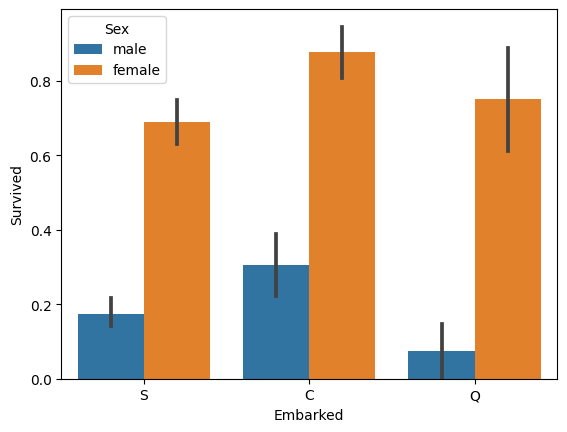

In [ ]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train);

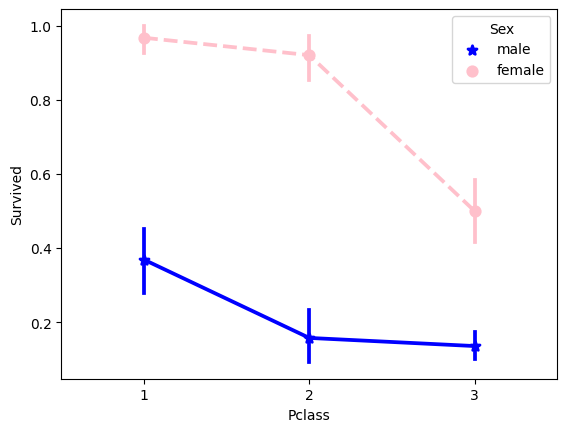

In [ ]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

**Limpeza e transformação de dados.**



*   Além de 'Sex', o feature 'Age' é o segundo em importância. Para evitar o overfitting, as pessoas serão agrupadas em grupos de idade.
*   Cada cabine começa com uma letra. Assim usaremos esta letra apenas.
*   A tarifa é outro valor contínuo que deve ser simplificado.
*   Extração de informações do feature 'Name'.
*   Descartar recursos inúteis. ('Ticket' e 'Name')



In [ ]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df
   
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


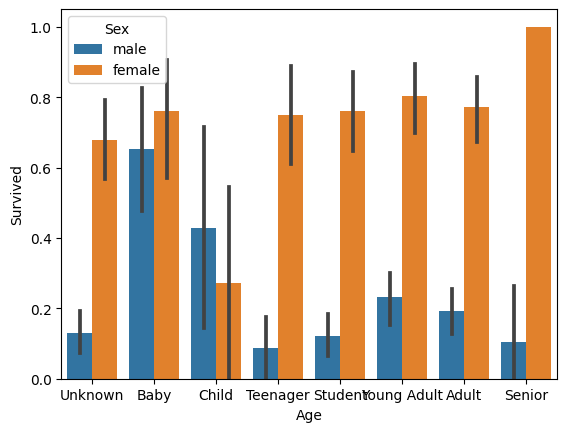

In [ ]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train);

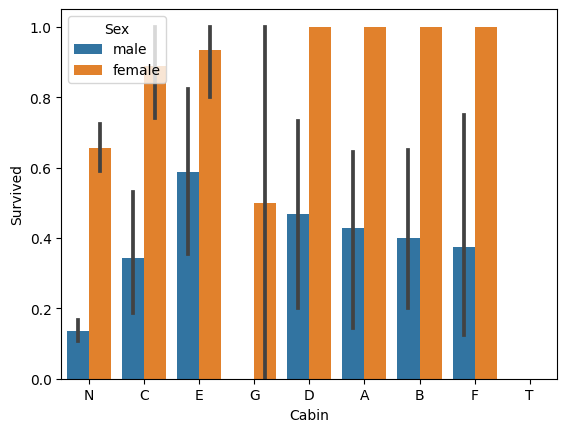

In [ ]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train);

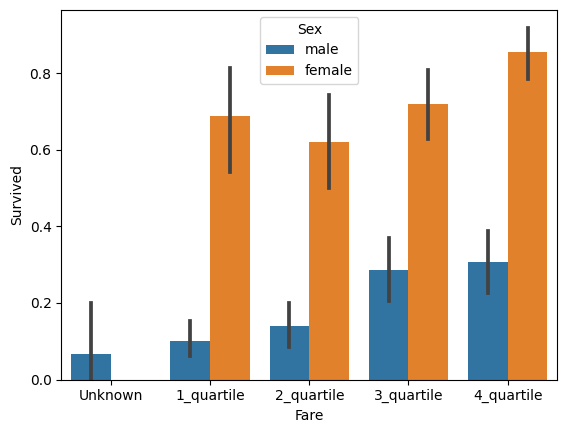

In [ ]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train);

**Codificação de dados.**

Para finalizar o pré-processamento precisa-se normalizar os rótulos. O LabelEncoder no Scikit-learn converterá cada valor único de string em um número, facilitando a aplicação de vários algoritmos.

O resultado é uma tabela de números.

In [ ]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


**Divisão de conjuntos de Treinamento e Teste.**

Aqui inicia-se a implementaçã de Machine Learning.

X_all: Todos os features menos o valor que queremos prever (Survived).

y_all: Apenas o valor que queremos prever.

O Scikit-learn embaralha aleatoriamente os dados e separa Treinamento 80% e teste 20%.

Posteriormente, esses dados serão reorganizados em um padrão KFold para validar a eficácia de um algoritmo.

In [ ]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

**Ajuste fino do algoritmo.**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='auto',
                       n_estimators=9)

In [ ]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8379888268156425
